<a href="https://colab.research.google.com/github/Ch4rlesSm1th99/CNN-MNIST-classifier-/blob/main/CNN's.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary


In [12]:
# MNIST
def mnist(batch_sz, valid_size=0.2, shuffle=True, random_seed=2000):
    # define classes
    num_classes = 10

    # define transformations for training data
    # randomly crops the images in 28*28 frame and then converts image to tensor
    transform_train = transforms.Compose([
        transforms.RandomCrop(28, padding=4),
        transforms.ToTensor(),
    ])

    # transformation for validation data (convert images to tensors)
    transform_valid = transforms.Compose([
        transforms.ToTensor(),
    ])

    # transformation for test data (convert images to tensors again)
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    # load training data with above transformations having beeen applied
    train_data = MNIST(root='./datasets', train=True, download=True, transform=transform_train)
    # load validation data from the same dataset but with transform valid applied
    valid_data = MNIST(root='./datasets', train=True, download=True, transform=transform_valid)

    # splits data set depending on size
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    # can shuffle data set with a new seed for retrialing
    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    # assign train and validation split
    train_idx, valid_idx = indices[split:], indices[:split]

    # create samplers that sample data during loading
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # create DataLoader for training data
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz, sampler=train_sampler, pin_memory=True)
    # create DataLoader for validation data
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_sz, sampler=valid_sampler, pin_memory=True)

    # load and create a dataLoader for test data
    test_data = MNIST(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_sz, shuffle=False, pin_memory=True)

    # return the dataLoader objects for training, validation, and testing
    return train_loader, valid_loader, test_loader



In [13]:
batch_sz=64
train_loader, valid_loader, test_loader=mnist(batch_sz)

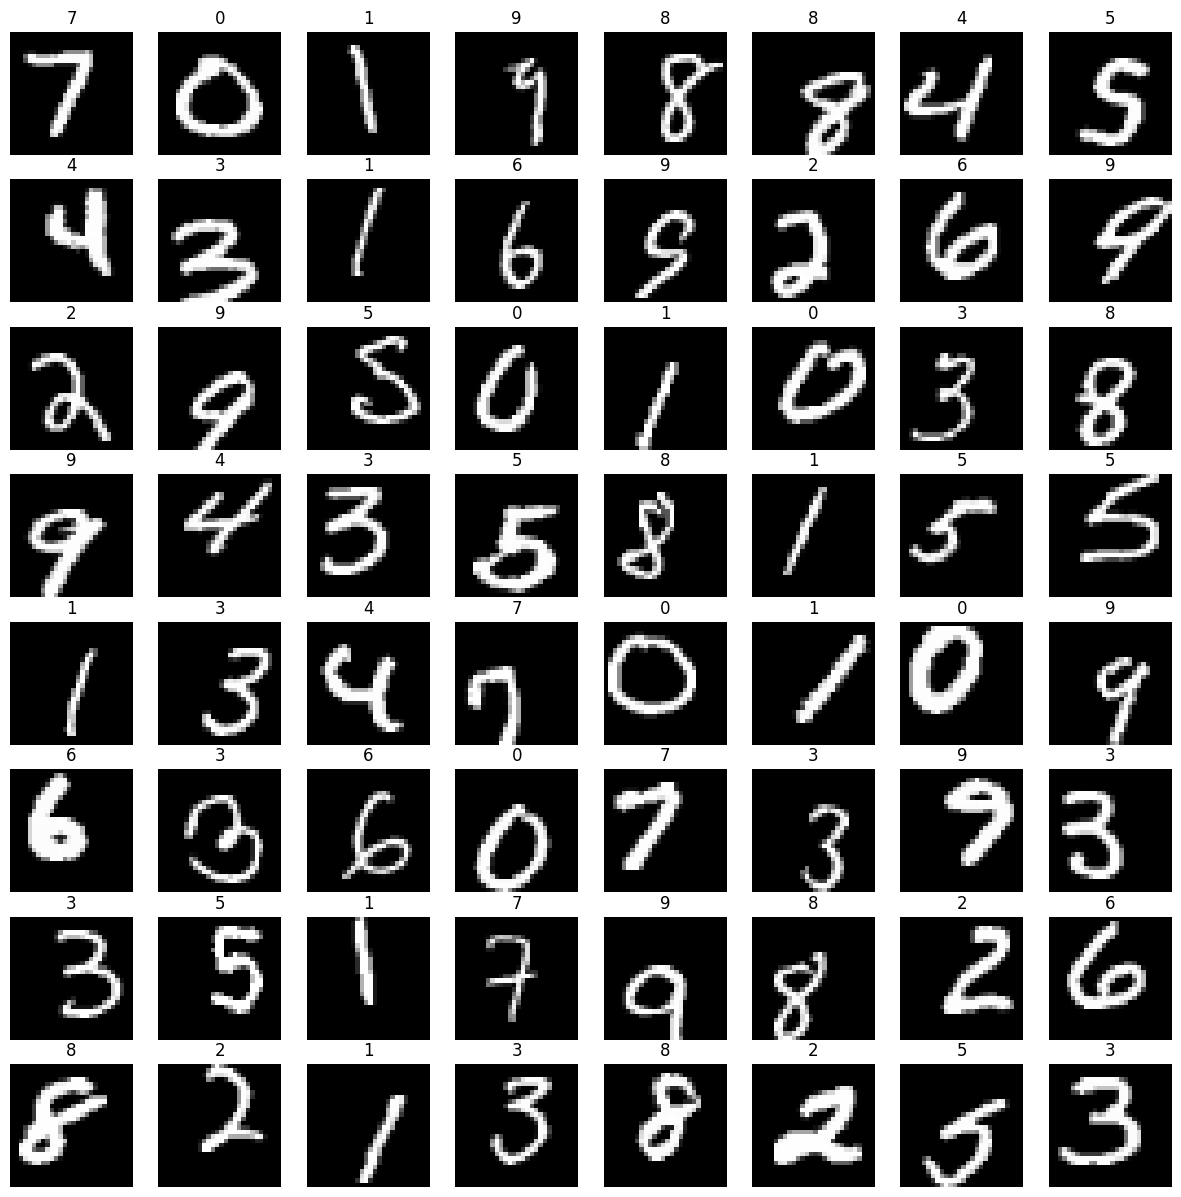

In [14]:
batch = next(iter(train_loader))
# separates the images and labels
images = batch[0]
labels = batch[1]

plt.figure(figsize=(15,15))

# loop over the first 64 images and labels in the batch and display plot with label
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(images[i, 0, :, :], cmap='gray')
    plt.title(labels[i].item())
    plt.axis("off")

plt.show()

In [16]:
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # input channels = 1 (for grayscale images), output channels = 50, kernel size = 3, stride = 1
        self.conv1 = nn.Conv2d(1, 50, 3, 1)
        # input channels = 50, output channels = 10, kernel size = 3, stride = 1
        self.conv2 = nn.Conv2d(50, 10, 3, 1)
        # input features = 10*2*2, output features = 100
        self.linear1 = nn.Linear(10*2*2, 100)
        # input features = 100, output features = 10
        self.linear2 = nn.Linear(100, 10)

    def forward(self, x):
        # input shape: (batch_size, 1, 28, 28)
        x = self.conv1(x)
        x = torch.relu(x)  # apply reLu activation function
        # Shape after conv1: (batch_size, 50, 26, 26)
        x1 = F.max_pool2d(x, (2, 2))  # apply max pooling with kernel size 2x2
        # shape after: (batch_size, 50, 13, 13)
        x = self.conv2(x1)  # apply the second convolutional layer
        x = torch.relu(x)
        # Shape after conv2: (batch_size, 10, 11, 11)
        x2 = F.max_pool2d(x, (4, 4))  # Apply max pooling with kernel size 4x4
        # Shape after pooling: (batch_size, 10, 2, 2)

        # classification part
        x3 = x2.view(-1, 10*2*2)  # Flatten the output for the linear layer
        # Shape before linear layers: (batch_size, 40)
        x = self.linear1(x3)  # Apply the first linear layer
        x = torch.relu(x)  # Apply ReLU activation function
        x = self.linear2(x)  # Apply the second linear layer
        # Output shape: (batch_size, 10)

        return x, x1, x2, x3



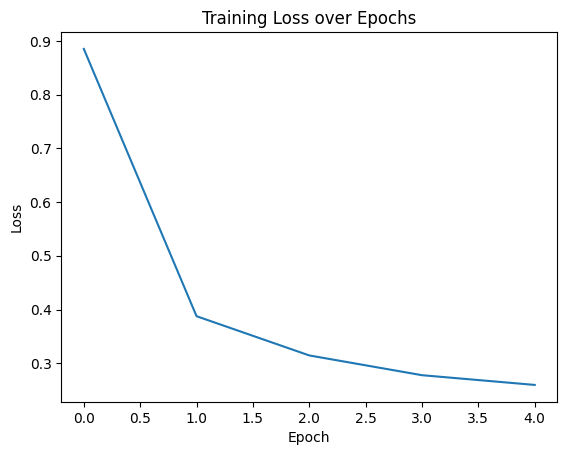

In [17]:
# initialise CNN and then move from CPU to GPU
device = torch.device("cuda:0")
net = MyCNN().to(device)

# parameters for SGD and initialisation of SGD
lr = .1
momentum = 0.5

opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)


num_epochs = 5
# store the loss values for each epoch
ls = []

for i in range(num_epochs):
    total_loss = 0  # initialize total loss for the epoch
    # iterate over the training data loader
    for batch in train_loader:
        # load a batch of input images and labels, and move them to the device
        X, Y = batch[0].to(device), batch[1].to(device)
        # forward pass: compute the predicted outputs by passing inputs to the model
        logits = net(X)[0]  # [0] to get the output of the network, ignoring intermediate outputs

        # compute the loss between the predicted outputs and true labels
        loss = F.cross_entropy(logits, Y)
        # zero the gradients before backward pass
        opt.zero_grad()
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        opt.step()
        # accumulate the loss
        total_loss += loss.item()

    #cCalculate and store the average loss for the epoch
    ls.append(total_loss / len(train_loader))

# plot the training loss over epochs
plt.plot(ls)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3], device='cuda:0')


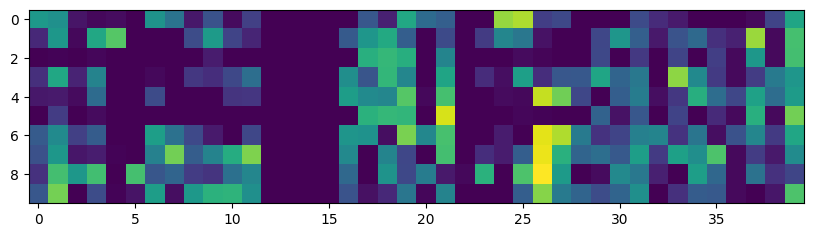

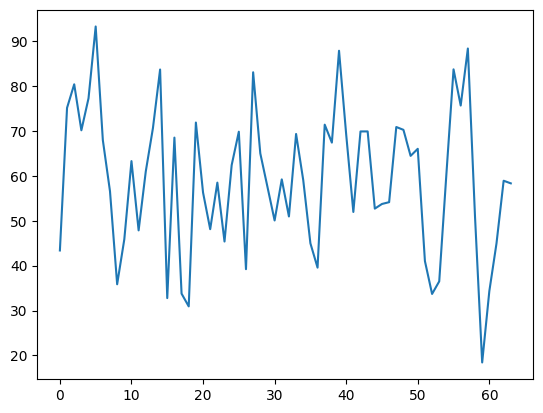

In [18]:
# gradients are no longer computed, testing mode
with torch.no_grad():
    batch = next(iter(test_loader))
    X, Y = batch[0].to(device), batch[1].to(device)

    # forward pass through the network to get the logits and activations from intermediate layers
    logits, Y1, Y2, Y3 = net(X)

    # detach the intermediate activations from the computation graph and move to CPU as NumPy arrays
    Y1 = Y1.detach().cpu().numpy()
    Y2 = Y2.detach().cpu().numpy()
    Y3 = Y3.detach().cpu().numpy()

    # visualize features from the flattened layer (Y3)
    plt.figure(figsize=(10,10))
    plt.imshow(Y3[:10,:])
    print(Y)

    plt.figure()
    # plot the dot product of the features of Y3 with the features of the third sample
    # this visualises the similarity between the feature representation of each sample in the batch and the third sample
    plt.plot(Y3[:,:] @ Y3[2,:].T)






<ipython-input-19-f2f90a62b8b6>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(w1.shape[1]*2, 2))


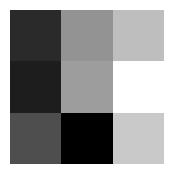

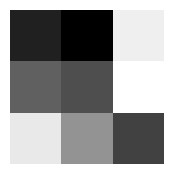

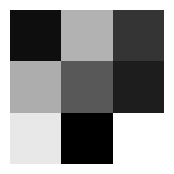

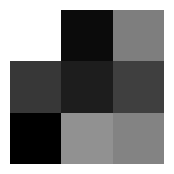

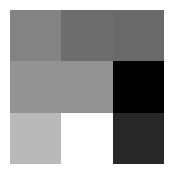

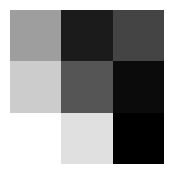

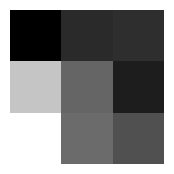

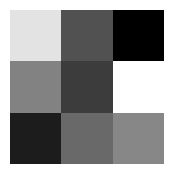

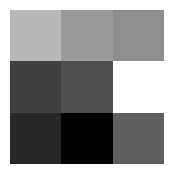

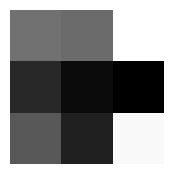

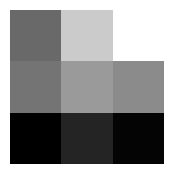

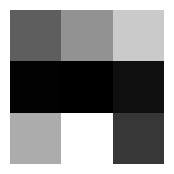

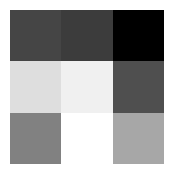

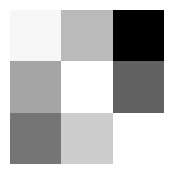

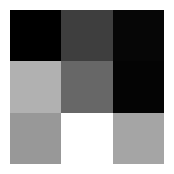

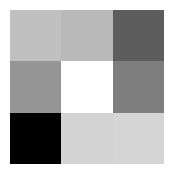

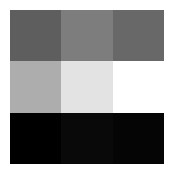

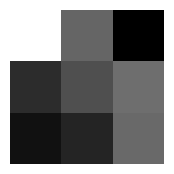

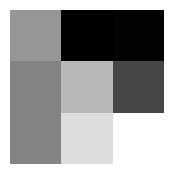

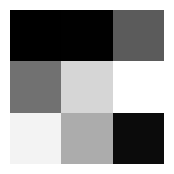

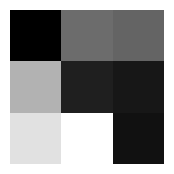

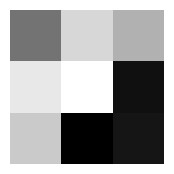

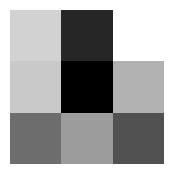

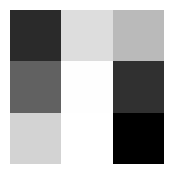

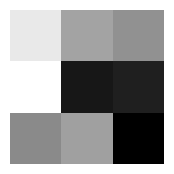

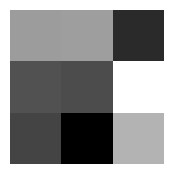

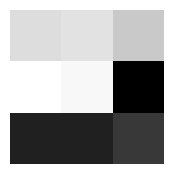

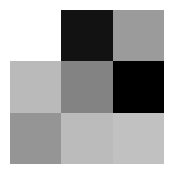

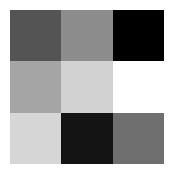

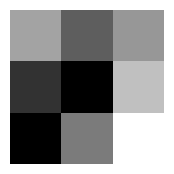

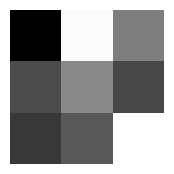

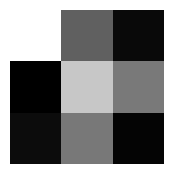

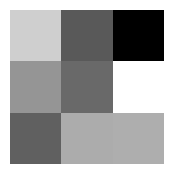

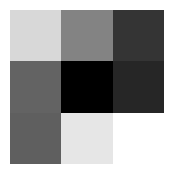

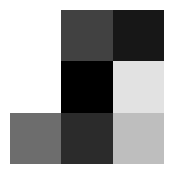

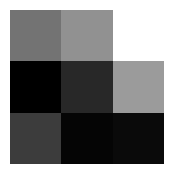

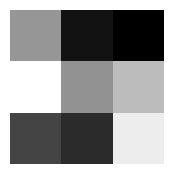

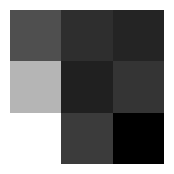

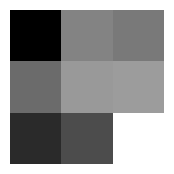

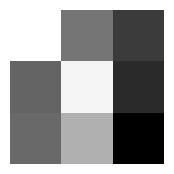

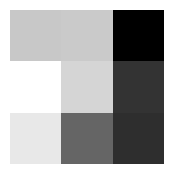

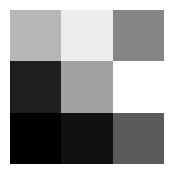

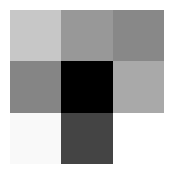

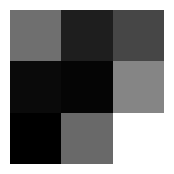

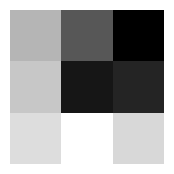

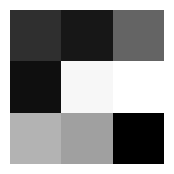

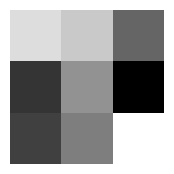

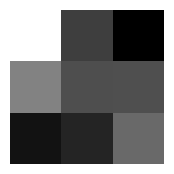

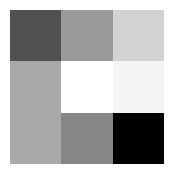

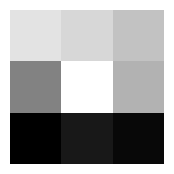

In [19]:
# move weights for 1st convolutional layer to CPU as Numpy arrays
w1 = net.conv1.weight.detach().cpu().numpy()

# iterate over all the filters in the first convolutional layer
for i in range(w1.shape[0]):
    # for each filter, a new fig displays the kernel
    plt.figure(figsize=(w1.shape[1]*2, 2))
    for j in range(w1.shape[1]):
        # creates a subplot for the j-th channel of the i-th filter
        # since we are dealing with grayscale hear the is only one channel per filter
        plt.subplot(1, w1.shape[1], j+1)
        plt.imshow(w1[i, j, :, :], cmap='gray')
        plt.axis('off')

plt.show()

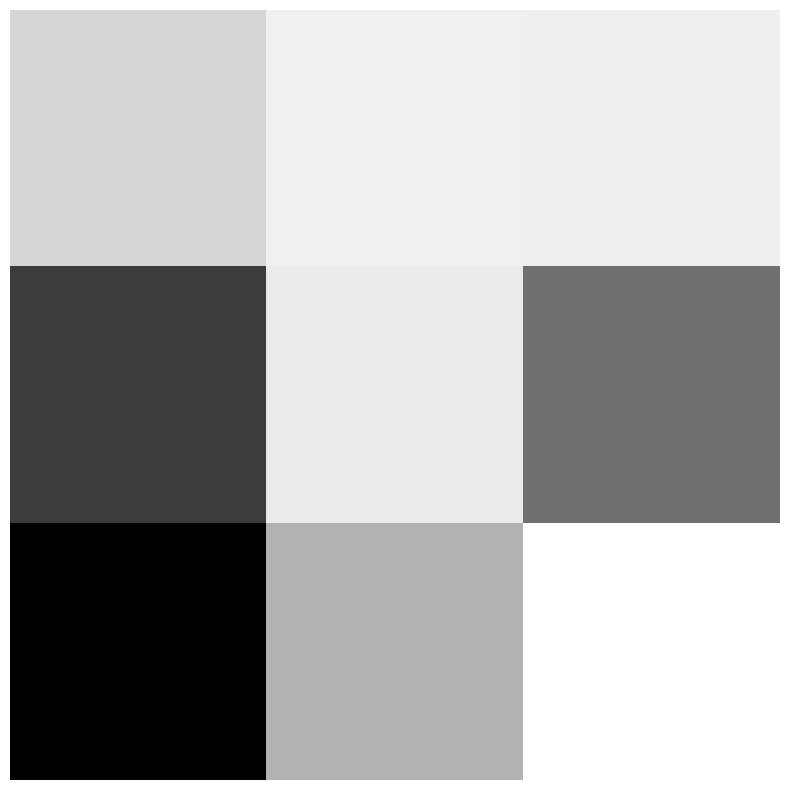

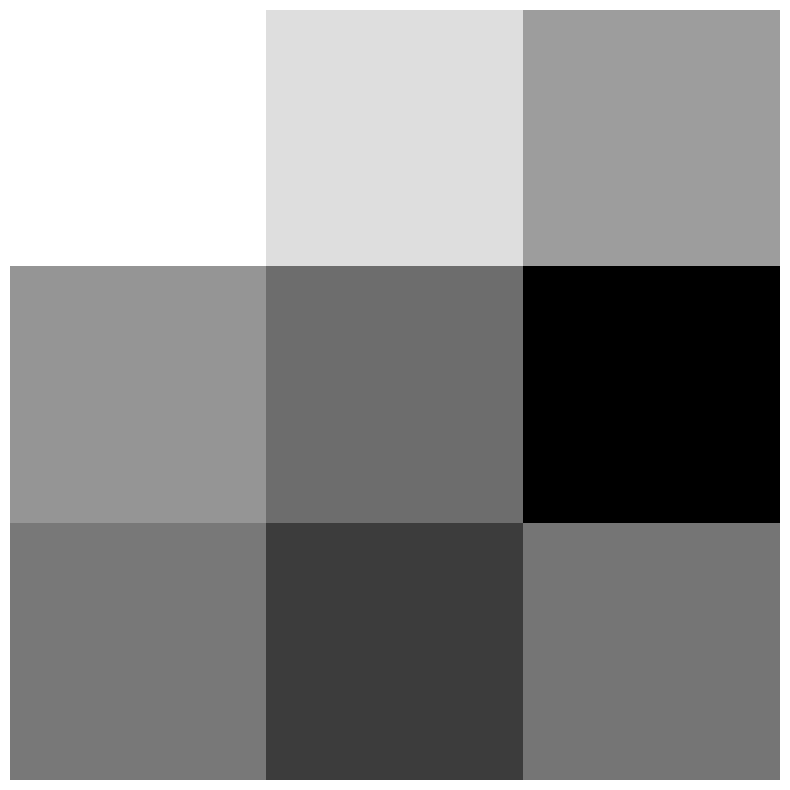

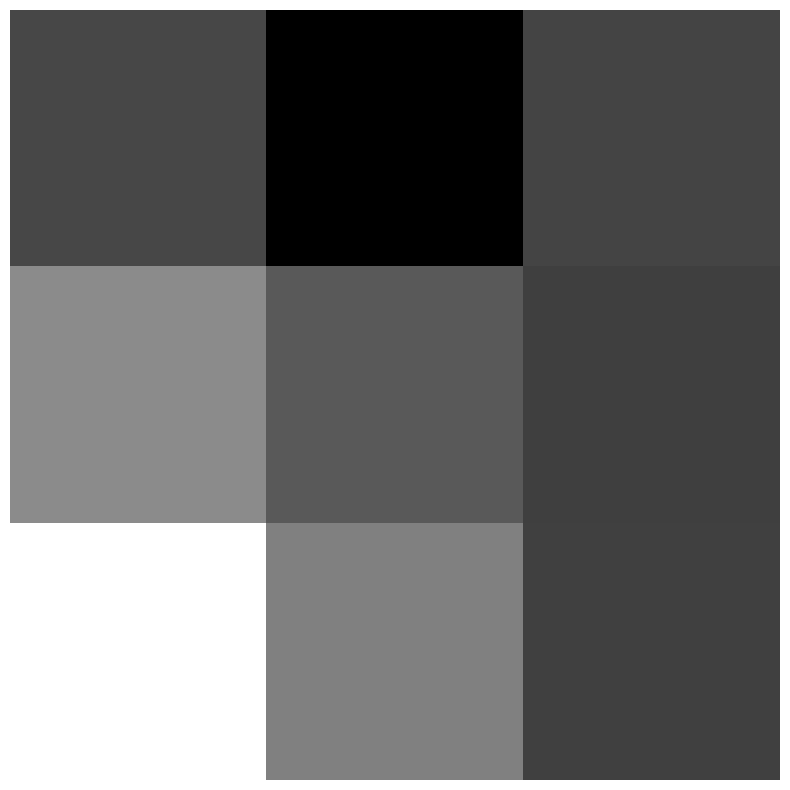

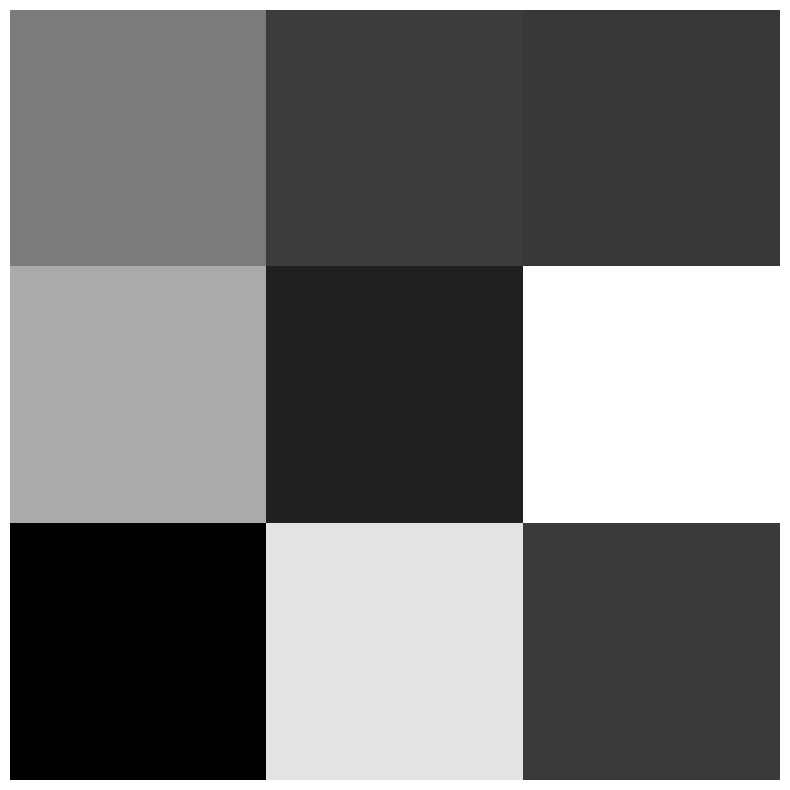

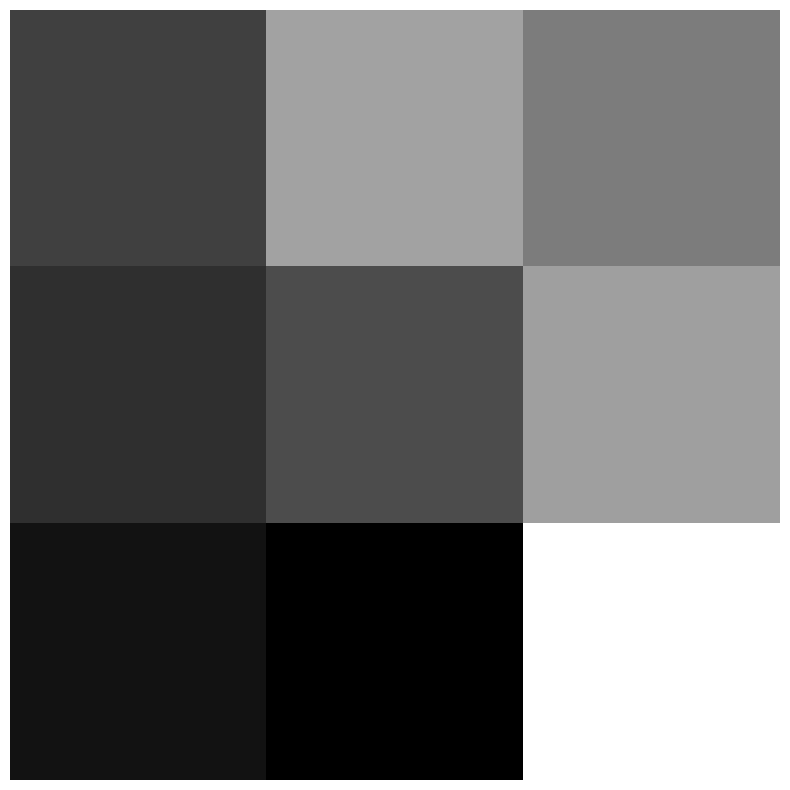

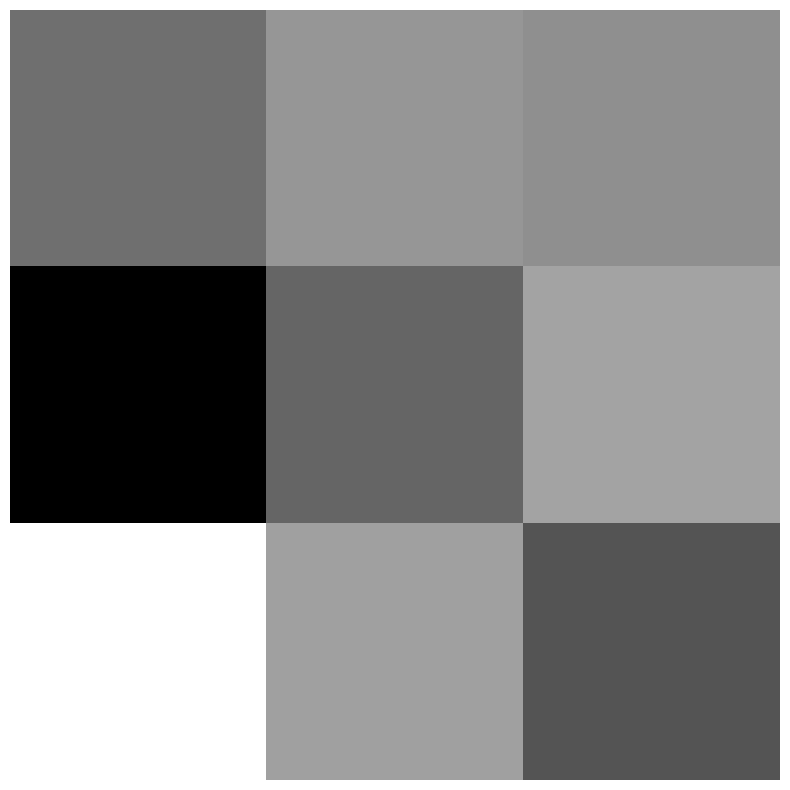

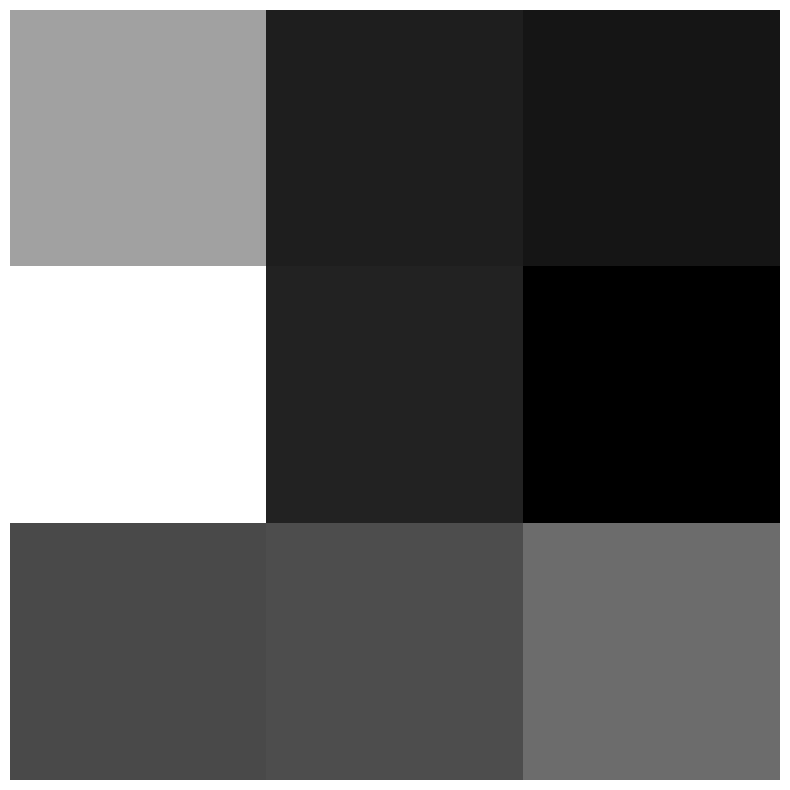

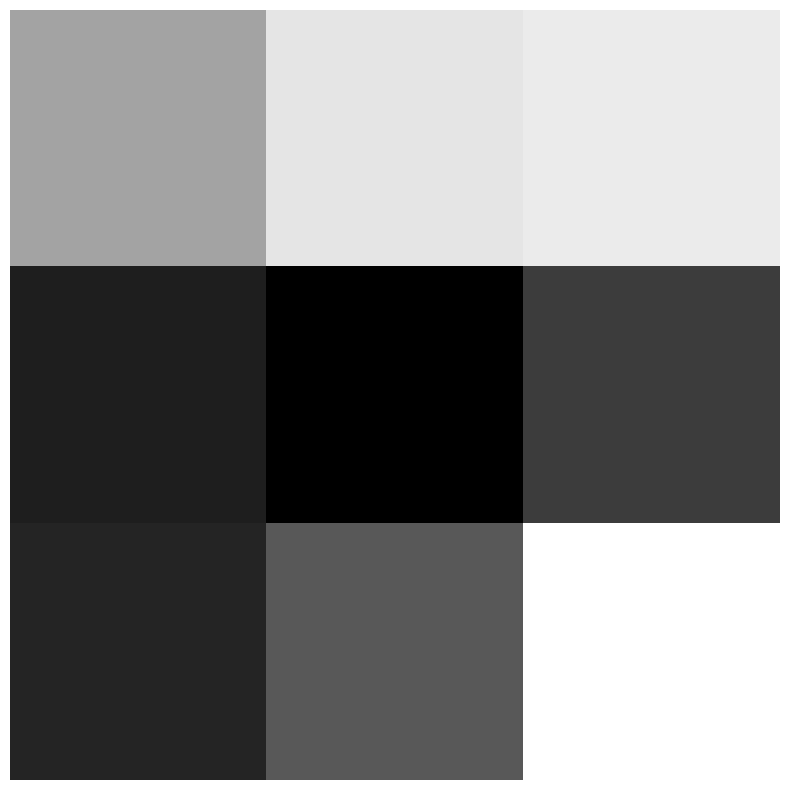

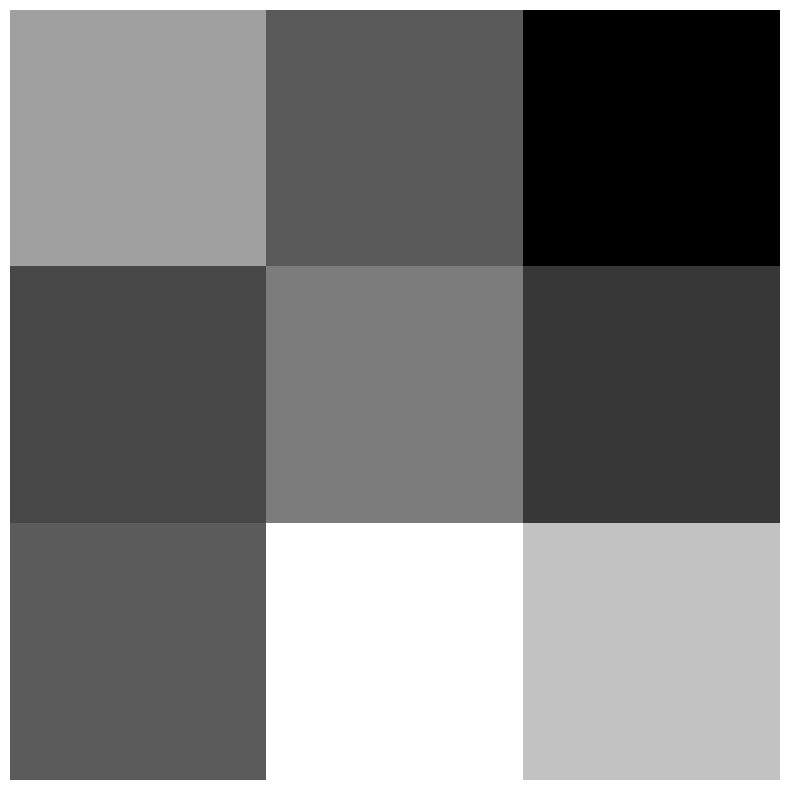

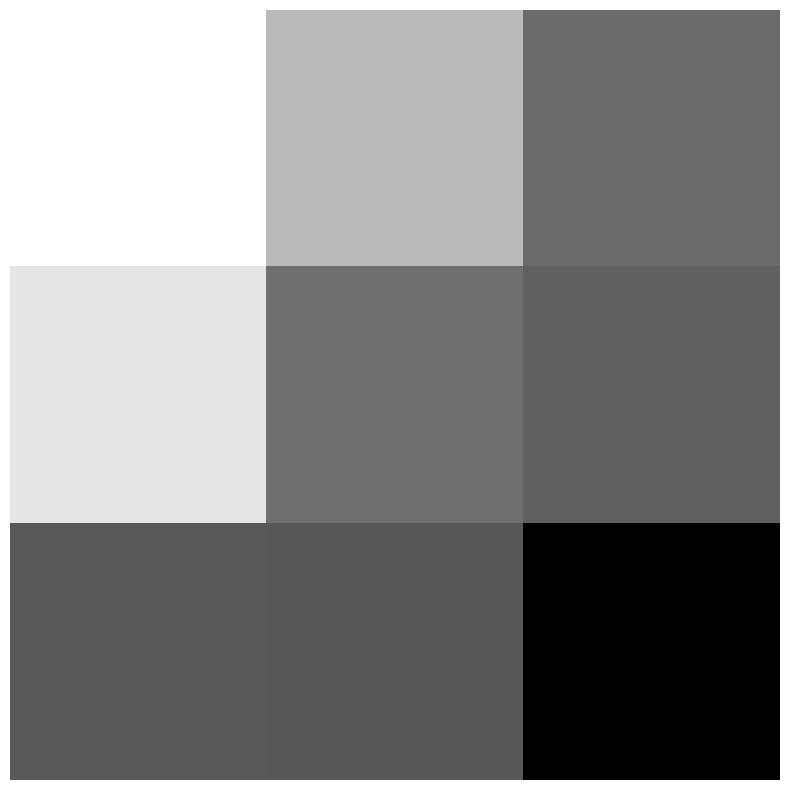

In [21]:
#perform the same for 2nd convo layer

w2 = net.conv2.weight.detach().cpu().numpy()
# w2 has shape (10, 50, 3, 3) for conv2


for i in range(w2.shape[0]):
    plt.figure(figsize=(10, 10))
    plt.imshow(w2[i, 0, :, :], cmap='gray')
    plt.axis("off")
    plt.show()

In [22]:
with torch.no_grad():
    correct = 0  # Initialize the count of correctly predicted samples
    total = 0  # Initialize the total count of samples processed

    # iterate over the test dataset
    for batch in test_loader:
        X, Y = batch[0].to(device), batch[1].to(device)
        logits, Y1, Y2, Y3 = net(X)  # Forward pass

        # move logits and labels to cpu
        logits = logits.detach().cpu().numpy()
        Y = Y.detach().cpu().numpy()

        # class prediction
        pred = np.argmax(logits, axis=1)

        # success count
        correct += np.sum(pred == Y)
        total += X.shape[0]

# overall accuracy
accuracy = correct / total

print(accuracy)

0.9598
